## <center> Exploring NYC to Open an Indian Restaurant </center>

<b> <center> This is the Final Capstone Project part of the IBM Applied Data Science Capstone on Coursera.</center> 

<p style="text-align: right;">By:<br>
                              Abhishek Mishra<br>
                              June 2020</p> </b>

### Import Packages

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
#!pip install geopy
from geopy.geocoders import Nominatim

import requests
#!pip install pandas.io
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium

### Declare credentials for Foursquare API

In [2]:
CLIENT_ID = ''         #declare id here
CLIENT_SECRET = ''     #declare secret here
VERSION = '20180605'   # Version of API
radius = 500           # Radius to search places
LIMIT = 100            # Max no.of data points to be returned

### Read and declare the data 

In [3]:
with open('ny_data.json') as json_data:      # Reading the json data saved locally
    ny_data = json.load(json_data)

ny_data = ny_data['features']                # The features key contains the data
ny_data[0]

{'type': 'Feature',
 'id': 1,
 'geometry': {'type': 'Point',
  'coordinates': [-73.8472019292043, 40.8947134741554]},
 'properties': {'FID': 1,
  'Name': 'Wakefield',
  'Stacked': 1,
  'AnnoLine1': 'Wakefield',
  'AnnoLine2': ' ',
  'AnnoLine3': ' ',
  'AnnoAngle': 0,
  'Borough': 'Bronx'}}

In [4]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_geo_data = pd.DataFrame(columns=column_names)                   # Create a dataframe to save the data into

for data in ny_data:
    borough = neighborhood_name = data['properties']['Borough'] 
    neighborhood_name = data['properties']['Name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_geo_data = ny_geo_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
print(ny_geo_data.shape)
ny_geo_data.head(10)     # Display

(306, 4)


Borough   Neighborhood   Latitude  Longitude
0          Bronx      Wakefield  40.894713 -73.847202
1          Bronx     Co-op City  40.874302 -73.829941
2          Bronx    Eastchester  40.887564 -73.827808
3          Bronx      Fieldston  40.895446 -73.905644
4          Bronx      Riverdale  40.890843 -73.912587
5          Bronx    Kingsbridge  40.881696 -73.902819
6  Staten Island    South Beach  40.580256 -74.079554
7      Manhattan    Marble Hill  40.876559 -73.910661
8  Staten Island  Port Richmond  40.633678 -74.129436
9          Bronx       Woodlawn  40.898281 -73.867316

### Count of NA's 

In [313]:
ny_geo_data.isna().sum()

Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

### Count of Neighborhoods in each Borough

In [311]:
temp = ny_geo_data.groupby('Borough').count().reset_index().rename(columns={'Neighborhood':'Count'})[['Borough','Count']].sort_values('Count',ascending=False).reset_index(drop=True)#.plot(x='Borough',y='Count',kind='bar')
temp

Borough  Count
0         Queens     81
1       Brooklyn     70
2  Staten Island     63
3          Bronx     52
4      Manhattan     40

### Function to the call the Foursquare API

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)   # The function returns a dataframe containing the nearby venues data obtained by calling the Foursquare API

### Queens

In [40]:
queens = ny_geo_data.loc[ny_geo_data['Borough']=='Queens'].reset_index(drop=True) # Filtering only Queens 
print(queens.shape)
queens.head()

(81, 4)


Borough     Neighborhood   Latitude  Longitude
0  Queens    Jamaica Hills  40.711468 -73.796466
1  Queens           Utopia  40.733509 -73.796718
2  Queens          Pomonok  40.734944 -73.804863
3  Queens  Astoria Heights  40.770326 -73.894681
4  Queens          Astoria  40.768517 -73.915655

In [41]:
queens_venues = getNearbyVenues(names=queens['Neighborhood'],latitudes=queens['Latitude'],longitudes=queens['Longitude'])
print(queens_venues.shape)   # Data returned by the API
queens_venues.head(10)

(2088, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Jamaica Hills              40.711468              -73.796466   
1  Jamaica Hills              40.711468              -73.796466   
2  Jamaica Hills              40.711468              -73.796466   
3  Jamaica Hills              40.711468              -73.796466   
4  Jamaica Hills              40.711468              -73.796466   
5  Jamaica Hills              40.711468              -73.796466   
6  Jamaica Hills              40.711468              -73.796466   
7  Jamaica Hills              40.711468              -73.796466   
8  Jamaica Hills              40.711468              -73.796466   
9  Jamaica Hills              40.711468              -73.796466   

                        Venue  Venue Latitude  Venue Longitude  \
0   Popeyes Louisiana Kitchen       40.709847       -73.795518   
1                  Genesis #1       40.708827       -73.799318   
2                  King Kabab       40.709936       -73.795289   
3            Sagar Restaurant       40.710329       -73.794123   
4                Annam Brahma       40.712781       -73.801283   
5   Popeyes Louisiana Kitchen       40.711604       -73.796629   
6                      Subway       40.709655       -73.794757   
7               Sagar Chinese       40.711129       -73.793021   
8                  Amina Thai       40.710897       -73.792330   
9  Richie's Place Coffee Shop       40.710595       -73.792963   

         Venue Category  
0   Fried Chicken Joint  
1  Caribbean Restaurant  
2      Halal Restaurant  
3     Indian Restaurant  
4     Indian Restaurant  
5   Fried Chicken Joint  
6        Sandwich Place  
7    Chinese Restaurant  
8       Thai Restaurant  
9           Coffee Shop

<b> Most common places in Queens</b>

In [43]:
q_temp = queens_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
q_temp.head()

Venue Category  Count
0         Pizza Place     88
1       Deli / Bodega     75
2  Chinese Restaurant     66
3              Bakery     56
4          Donut Shop     52

### Brooklyn

In [8]:
brook = ny_geo_data.loc[ny_geo_data['Borough']=='Brooklyn'].reset_index(drop=True)  #Filtering only Brooklyn
print(brook.shape)
brook.head()

(70, 4)


Borough Neighborhood   Latitude  Longitude
0  Brooklyn  Ditmas Park  40.643683 -73.961015
1  Brooklyn      Wingate  40.660955 -73.937188
2  Brooklyn        Rugby  40.655581 -73.926884
3  Brooklyn    Bay Ridge  40.625809 -74.030622
4  Brooklyn  Bensonhurst  40.611017 -73.995181

In [9]:
brook_venues = getNearbyVenues(names=brook['Neighborhood'],latitudes=brook['Latitude'],longitudes=brook['Longitude'])
print(brook_venues.shape)
brook_venues.head(10)

(2719, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Ditmas Park              40.643683              -73.961015   
1  Ditmas Park              40.643683              -73.961015   
2  Ditmas Park              40.643683              -73.961015   
3  Ditmas Park              40.643683              -73.961015   
4  Ditmas Park              40.643683              -73.961015   
5  Ditmas Park              40.643683              -73.961015   
6  Ditmas Park              40.643683              -73.961015   
7  Ditmas Park              40.643683              -73.961015   
8  Ditmas Park              40.643683              -73.961015   
9  Ditmas Park              40.643683              -73.961015   

                Venue  Venue Latitude  Venue Longitude        Venue Category  
0       Cafe Madeline       40.641689       -73.963349           Coffee Shop  
1     Pasture Burgers       40.641970       -73.963182          Burger Joint  
2     Crunch Flatbush       40.645798       -73.958149  Gym / Fitness Center  
3       Kings Theatre       40.646110       -73.957175               Theater  
4          Cafe Tibet       40.641243       -73.964064    Tibetan Restaurant  
5  Kings County Wines       40.641100       -73.964489             Wine Shop  
6     Ayurvedic Plate       40.641686       -73.962914                  Café  
7      FIB Tattoo Bar       40.645226       -73.957701                   Bar  
8      Island Express       40.647111       -73.958108  Caribbean Restaurant  
9  Flatbush Food Coop       40.641196       -73.964675     Health Food Store

<b> Most common places in Brooklyn </b>

In [44]:
bk_temp = brook_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
bk_temp.head()

Venue Category  Count
0    Pizza Place    128
1    Coffee Shop     98
2            Bar     83
3  Deli / Bodega     69
4         Bakery     65

### Staten Island

In [11]:
stat_island = ny_geo_data.loc[ny_geo_data['Borough']=='Staten Island'].reset_index(drop=True)  #Filtering only Staten Island
print(stat_island.shape)
stat_island.head()

(63, 4)


Borough       Neighborhood   Latitude  Longitude
0  Staten Island        South Beach  40.580256 -74.079554
1  Staten Island      Port Richmond  40.633678 -74.129436
2  Staten Island   Mariner's Harbor  40.632555 -74.150087
3  Staten Island         Port Ivory  40.639691 -74.174647
4  Staten Island  Castleton Corners  40.613344 -74.119182

In [12]:
si_venues = getNearbyVenues(names=stat_island['Neighborhood'],latitudes=stat_island['Latitude'],longitudes=stat_island['Longitude'])
print(si_venues.shape)
si_venues.head(10)

(850, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    South Beach              40.580256              -74.079554   
1    South Beach              40.580256              -74.079554   
2    South Beach              40.580256              -74.079554   
3    South Beach              40.580256              -74.079554   
4    South Beach              40.580256              -74.079554   
5    South Beach              40.580256              -74.079554   
6    South Beach              40.580256              -74.079554   
7  Port Richmond              40.633678              -74.129436   
8  Port Richmond              40.633678              -74.129436   
9  Port Richmond              40.633678              -74.129436   

                                               Venue  Venue Latitude  \
0                    Franklin D. Roosevelt Boardwalk       40.579832   
1        Ocean Breeze Track & Field Athletic Complex       40.583038   
2                         Midland Beach Fishing Pier       40.579812   
3                                     Oceanview Deli       40.579208   
4                                       Amazing Deli       40.579207   
5                                      FDR Boardwalk       40.580115   
6                                  Ocean Breeze Pier       40.577977   
7                              Enterprise Rent-A-Car       40.636944   
8                                            Dunkin'       40.637225   
9  MTA Bus - Castleton Av & Jewett Av (S46/S53/S6...       40.633846   

   Venue Longitude       Venue Category  
0       -74.076147                Beach  
1       -74.075244   Athletics & Sports  
2       -74.076066                 Pier  
3       -74.078926        Deli / Bodega  
4       -74.078923        Deli / Bodega  
5       -74.076095                Beach  
6       -74.075366                 Pier  
7       -74.127005  Rental Car Location  
8       -74.127623           Donut Shop  
9       -74.129698             Bus Stop

<b> Most common places in Staten Island </b>

In [45]:
si_temp = si_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
si_temp.head()

Venue Category  Count
0         Pizza Place     55
1            Bus Stop     52
2       Deli / Bodega     41
3  Italian Restaurant     40
4            Pharmacy     21

### Bronx

In [14]:
bronx = ny_geo_data.loc[ny_geo_data['Borough']=='Bronx'].reset_index(drop=True)  #Filtering only Bronx
print(bronx.shape)
bronx.head()

(52, 4)


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894713 -73.847202
1   Bronx   Co-op City  40.874302 -73.829941
2   Bronx  Eastchester  40.887564 -73.827808
3   Bronx    Fieldston  40.895446 -73.905644
4   Bronx    Riverdale  40.890843 -73.912587

In [15]:
bronx_venues = getNearbyVenues(names=bronx['Neighborhood'],latitudes=bronx['Latitude'],longitudes=bronx['Longitude'])
print(bronx_venues.shape)
bronx_venues.head(10)

(1180, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894713              -73.847202   
1    Wakefield              40.894713              -73.847202   
2    Wakefield              40.894713              -73.847202   
3    Wakefield              40.894713              -73.847202   
4    Wakefield              40.894713              -73.847202   
5    Wakefield              40.894713              -73.847202   
6    Wakefield              40.894713              -73.847202   
7    Wakefield              40.894713              -73.847202   
8    Wakefield              40.894713              -73.847202   
9    Wakefield              40.894713              -73.847202   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1         Walgreens       40.896528       -73.844700        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop  
5             Shell       40.894187       -73.845862     Gas Station  
6            Subway       40.890468       -73.849152  Sandwich Place  
7       Pitman Deli       40.896744       -73.844398            Food  
8       Louis Pizza       40.898399       -73.848810     Pizza Place  
9   Koss Quick Wash       40.891281       -73.849904      Laundromat

<b> Most common places in Bronx </b>

In [46]:
br_temp = bronx_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
br_temp.head()

Venue Category  Count
0    Pizza Place     99
1  Deli / Bodega     56
2       Pharmacy     44
3     Donut Shop     43
4  Grocery Store     38

### Manhattan

In [17]:
manhattan = ny_geo_data.loc[ny_geo_data['Borough']=='Manhattan'].reset_index(drop=True)  #Filtering Manhattan
print(manhattan.shape)
manhattan.head()

(40, 4)


Borough      Neighborhood   Latitude  Longitude
0  Manhattan       Marble Hill  40.876559 -73.910661
1  Manhattan            Inwood  40.867692 -73.921212
2  Manhattan  Hamilton Heights  40.823613 -73.949689
3  Manhattan    Manhattanville  40.816943 -73.957387
4  Manhattan    Central Harlem  40.815984 -73.943213

In [19]:
manhattan_venues = getNearbyVenues(names=manhattan['Neighborhood'],latitudes=manhattan['Latitude'],longitudes=manhattan['Longitude'])
print(manhattan_venues.shape)
manhattan_venues.head(10)

(3137, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876559              -73.910661   
1  Marble Hill              40.876559              -73.910661   
2  Marble Hill              40.876559              -73.910661   
3  Marble Hill              40.876559              -73.910661   
4  Marble Hill              40.876559              -73.910661   
5  Marble Hill              40.876559              -73.910661   
6  Marble Hill              40.876559              -73.910661   
7  Marble Hill              40.876559              -73.910661   
8  Marble Hill              40.876559              -73.910661   
9  Marble Hill              40.876559              -73.910661   

                              Venue  Venue Latitude  Venue Longitude  \
0                          Arturo's       40.874412       -73.910271   
1                       Bikram Yoga       40.876844       -73.906204   
2                     Tibbett Diner       40.880404       -73.908937   
3                         Starbucks       40.877531       -73.905582   
4                           Dunkin'       40.877136       -73.906666   
5                          Rite Aid       40.875467       -73.908906   
6  Astral Fitness & Wellness Center       40.876705       -73.906372   
7                     Blink Fitness       40.877271       -73.905595   
8                         Starbucks       40.873755       -73.908613   
9         TCR The Club of Riverdale       40.878628       -73.914568   

   Venue Category  
0     Pizza Place  
1     Yoga Studio  
2           Diner  
3     Coffee Shop  
4      Donut Shop  
5        Pharmacy  
6             Gym  
7             Gym  
8     Coffee Shop  
9  Tennis Stadium

<b> Most common places in Manhattan </b>

In [47]:
m_temp = manhattan_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
m_temp.head()

Venue Category  Count
0          Coffee Shop    145
1   Italian Restaurant    123
2                 Café     84
3          Pizza Place     74
4  American Restaurant     72

### Indian Restaurant's in various Boroughs

In [54]:
a = q_temp[q_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Queens'}) # Getting the Number of Indian Restaurants in all the Boroughs
b = bk_temp[bk_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Brooklyn'})
c = si_temp[si_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Staten Island'})
d = br_temp[br_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Bronx'})
e = m_temp[m_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Manhattan'})

In [304]:
plt.rcParams['figure.figsize'] = 10,5

<b> Ranking the Borough's by number of Indian Restaurant's</b>

Borough Indian Restaurant
0      Manhattan                24
1         Queens                23
2       Brooklyn                14
3          Bronx                 3
4  Staten Island                 2

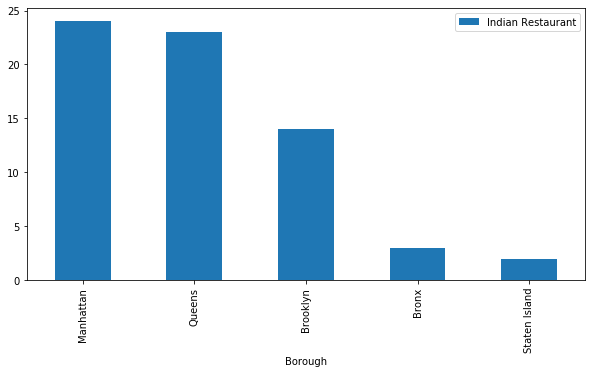

In [305]:
rest_count = pd.merge(a,b,on='Venue Category',how='inner').merge(c,on='Venue Category').merge(d,on='Venue Category').merge(e,on='Venue Category')
rest_count = rest_count.transpose().reset_index() # Merging all the Boroughs and transpose
rest_count.columns=['Borough','Indian Restaurant']
rest_count.drop([0],inplace=True)
rest_count = rest_count.sort_values('Indian Restaurant',ascending=False).reset_index(drop=True) # Sorting
rest_count.plot(x='Borough',kind='bar')
rest_count

<b> Manhattan has the highest number of restaurants (24) and Queens is 2<sup>nd</sup> highest with 23 Places.<br>Before we analyze a Borough we must look into the Indian Demographic of each of them.</b>

### Getting Indians living in NYC
<b>Based on a 2014 American Community Survey. (ACS) </b>

In [308]:
ny_india = pd.read_html('https://en.wikipedia.org/wiki/Indians_in_the_New_York_City_metropolitan_region') # Scraping Demographics Data
ny_india = ny_india[1]
ny_india.head()

Rank               Borough           City  Indian Americans  \
0   1.0     Queens (2014)[33]  New York City            144896   
1   2.0       Brooklyn (2012)  New York City             25270   
2   3.0      Manhattan (2012)  New York City             24359   
3   4.0      The Bronx (2012)  New York City             16748   
4   5.0  Staten Island (2012)  New York City              6646   

   Density of Indian Americans per square mile  \
0                                       1326.5   
1                                        357.9   
2                                       1060.9   
3                                        398.6   
4                                        113.6   

   Percentage of Indian Americans in municipality's population  
0                                                6.2            
1                                                1.0            
2                                                1.5            
3                                                1.2            
4                                                1.4

### Cleaning the Demographics Data

In [309]:
ny_india.drop(columns=['Rank','City'],axis=1,inplace=True)      # Drop the rank and City and the Total Row
ny_india.drop([5],axis=0,inplace=True)

Borough  Indian Americans  \
0         Queens            144896   
1       Brooklyn             25270   
2  Staten Island             24359   
3          Bronx             16748   
4      Manhattan              6646   

   Density of Indian Americans per square mile  % Population  
0                                       1326.5           6.2  
1                                        357.9           1.0  
2                                       1060.9           1.5  
3                                        398.6           1.2  
4                                        113.6           1.4

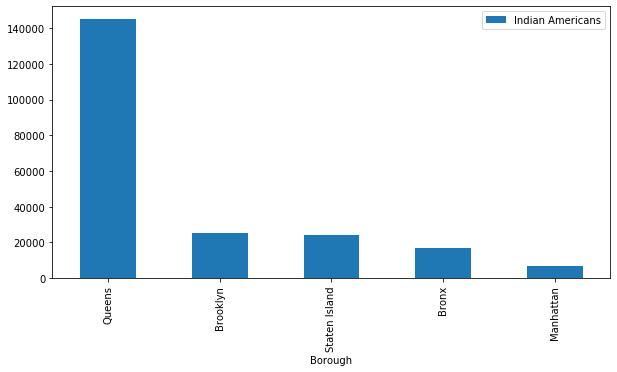

In [312]:
ny_india['Borough'] = temp['Borough']        # Making the data more presentable
ny_india.rename(columns={'''Percentage of Indian Americans in municipality's population''':'% Population'},inplace=True)
ny_india.plot(x='Borough',y='Indian Americans',kind='bar')
ny_india

### Merging the Count of Restaurants and the Indian Demographic

In [101]:
pd.merge(rest_count,ny_india,on='Borough',how='inner').sort_values(by=['Indian Americans','Indian Restaurant'],ascending=False).reset_index(drop=True)

Borough Indian Restaurant  Indian Americans  \
0         Queens                23            144896   
1       Brooklyn                14             25270   
2  Staten Island                 2             24359   
3          Bronx                 3             16748   
4      Manhattan                24              6646   

   Density of Indian Americans per square mile  % Population  
0                                       1326.5           6.2  
1                                        357.9           1.0  
2                                       1060.9           1.5  
3                                        398.6           1.2  
4                                        113.6           1.4

### Initial Analysis:

<b><p> Although Queens has the highest population of Indian Americans and the highest % population, we don't consider it as there are already numerous pre-existing restaurants.</p> <br> 
<p> Manhattan has very few Indian Americans with a low % and also has the most no. of Indian Restaurants, so we eliminate it. </p> <br> 
<p> Brooklyn seems like a good first choice to begin our analysis as it it does not have too may restaurants with a decent Indian Population. <br> Staten Island can also be looked into next (High population density with very few places). </p> </b>

## Case 1 : Brooklyn

### Visualizaing a map of Brooklyn

In [293]:
def location(place): # Function uses Geoencoder to get the coordinates of a location 
    l=[]
    address = place
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    l.append(latitude)
    l.append(longitude)
    print('The geograpical coordinate of {} are {}, {}.'.format(place.split(',')[0],latitude, longitude))
    return l   

In [297]:
loc = location('Brooklyn, NY')

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [302]:
def plot_map(df,loc,zoom):  # Function to plot a map, it takes a dataframe,list location and zoom value as parameters 
    #create a map with the location values
    map_df = folium.Map(location=loc, zoom_start=zoom)
    # add markers to map
    for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='purple',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_df)  
    #return the map object
    return map_df

In [298]:
plot_map(brook,loc,zoom=11)

### Filtering

In [201]:
brook_indian = brook_venues[brook_venues['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
brook_indian.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Bay Ridge              40.625809              -74.030622   
1        Greenpoint              40.730209              -73.954242   
2          Bushwick              40.698124              -73.925259   
3  Brooklyn Heights              40.695872              -73.993784   
4  Brooklyn Heights              40.695872              -73.993784   

                    Venue  Venue Latitude  Venue Longitude     Venue Category  
0            Bombay Grill       40.622371       -74.031799  Indian Restaurant  
1          Agra Taj Mahal       40.733321       -73.954928  Indian Restaurant  
2            Agra Heights       40.698094       -73.921355  Indian Restaurant  
3           Curry Heights       40.693572       -73.992265  Indian Restaurant  
4  Asya Indian Restaurant       40.699607       -73.992110  Indian Restaurant

### OneHot Encoding the Cateogories

In [214]:
ny_onehot = pd.get_dummies(brook_venues[['Venue Category']], prefix="", prefix_sep="")   # Using dummies to Encode
ny_onehot['Neighborhood'] = brook_venues['Neighborhood']

fixed_columns = [ny_onehot.columns[182]] + list(ny_onehot.columns[:182]) + list(ny_onehot.columns[183:])  # Getting the Neighborhoods column to the first
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(2719, 285)


Neighborhood  Accessories Store  Adult Boutique  Airport Terminal  \
0  Ditmas Park                  0               0                 0   
1  Ditmas Park                  0               0                 0   
2  Ditmas Park                  0               0                 0   
3  Ditmas Park                  0               0                 0   
4  Ditmas Park                  0               0                 0   

   American Restaurant  Antique Shop  Arepa Restaurant  \
0                    0             0                 0   
1                    0             0                 0   
2                    0             0                 0   
3                    0             0                 0   
4                    0             0                 0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                       0            0                    0   
1                       0            0                    0   
2                       0            0                    0   
3                       0            0                    0   
4                       0            0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                     0                 0                   0            0   
1                     0                 0                   0            0   
2                     0                 0                   0            0   
3                     0                 0                   0            0   
4                     0                 0                   0            0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0          0           0       0     0    0               0                 0   
1          0           0       0     0    0               0                 0   
2          0           0       0     0    0               0                 0   
3          0           0       0     0    0               0                 0   
4          0           0       0     0    0               0                 0   

   Basketball Court  Beach  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                 0      0         0            0           0              0   
1                 0      0         0            0           0              0   
2                 0      0         0            0           0              0   
3                 0      0         0            0           0              0   
4                 0      0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  Boat or Ferry  \
0                         0          0       0           0              0   
1                         0          0       0           0              0   
2                         0          0       0           0              0   
3                         0          0       0           0              0   
4                         0          0       0           0              0   

   Bookstore  Boutique  Boxing Gym  Breakfast Spot  Brewery  Bridge  \
0          0         0           0               0        0       0   
1          0         0           0               0        0       0   
2          0         0           0               0        0       0   
3          0         0           0               0        0       0   
4          0         0           0               0        0       0   

   Bubble Tea Shop  Buffet  Burger Joint  Burrito Place  Bus Line  \
0                0       0             0              0         0   
1                0       0             1              0         0   
2                0       0             0              0         0   
3                0       0             0              0         0   
4                0       0             0              0         0   

   Bus Station  Bus Stop  Business Service  Butcher  Café  \
0            0         0                 0  

### Grouping the Categories

In [215]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()  # Grouping and taking the mean
print(ny_grouped.shape)
ny_grouped.head()

(70, 285)


Neighborhood  Accessories Store  Adult Boutique  Airport Terminal  \
0          Bath Beach           0.020833             0.0               0.0   
1           Bay Ridge           0.000000             0.0               0.0   
2  Bedford Stuyvesant           0.000000             0.0               0.0   
3         Bensonhurst           0.000000             0.0               0.0   
4        Bergen Beach           0.000000             0.0               0.0   

   American Restaurant  Antique Shop  Arepa Restaurant  \
0               0.0000           0.0               0.0   
1               0.0375           0.0               0.0   
2               0.0000           0.0               0.0   
3               0.0000           0.0               0.0   
4               0.0000           0.0               0.0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                     0.0          0.0                  0.0   
1                     0.0          0.0                  0.0   
2                     0.0          0.0                  0.0   
3                     0.0          0.0                  0.0   
4                     0.0          0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                   0.0          0.020833            0.000000          0.0   
1                   0.0          0.000000            0.000000          0.0   
2                   0.0          0.000000            0.000000          0.0   
3                   0.0          0.031250            0.000000          0.0   
4                   0.0          0.000000            0.166667          0.0   

   BBQ Joint  Bagel Shop    Bakery      Bank       Bar  Baseball Field  \
0   0.000000    0.020833  0.020833  0.020833  0.000000        0.000000   
1   0.000000    0.025000  0.000000  0.000000  0.037500        0.000000   
2   0.035714    0.035714  0.000000  0.000000  0.071429        0.000000   
3   0.000000    0.031250  0.031250  0.031250  0.000000        0.000000   
4   0.000000    0.000000  0.000000  0.000000  0.000000        0.166667   

   Baseball Stadium  Basketball Court  Beach  Beer Bar  Beer Garden  \
0               0.0               0.0    0.0       0.0          0.0   
1               0.0               0.0    0.0       0.0          0.0   
2               0.0               0.0    0.0       0.0          0.0   
3               0.0               0.0    0.0       0.0          0.0   
4               0.0               0.0    0.0       0.0          0.0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  \
0         0.0            0.0                       0.0        0.0     0.0   
1         0.0            0.0                       0.0        0.0     0.0   
2         0.0            0.0                       0.0        0.0     0.0   
3         0.0            0.0                       0.0        0.0     0.0   
4         0.0            0.0                       0.0        0.0     0.0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Boxing Gym  Breakfast Spot  \
0         0.0            0.0     0.0000  0.000000         0.0          0.0000   
1         0.0            0.0     0.0125  0.000000         0.0          0.0125   
2         0.0            0.0     0.0000  0.035714         0.0          0.0000   
3         0.0            0.0     0.0000  0.000000         0.0          0.0000   
4         0.0            0.0     0.0000  0.000000         0.0          0.0000   

   Brewery  Bridge  Bubble Tea Shop  Buffet  Burger Joint  Burrito Place  \
0      0.0     0.0         0.041667     0.0      0.020833            0.0   
1      0.0     0.0         0.000000     0.0      0.000000            0.0   
2      0.0     0.0         0.000000     0.0      0.000000            0.0   
3      0.0     0.0         0.000000     0.0      0.000000            0.0   
4      0.0     0.0         0.000000     0.0      0.000000            0.0   

   Bus Line  Bus Station  Bus Stop  Business Service  Butcher   

In [216]:
grouped_indian = ny_grouped[['Neighborhood','Indian Restaurant']]  # Only Indian Restaurant needs to be considered
grouped_indian.head()

Neighborhood  Indian Restaurant
0          Bath Beach             0.0000
1           Bay Ridge             0.0125
2  Bedford Stuyvesant             0.0000
3         Bensonhurst             0.0000
4        Bergen Beach             0.0000

### Clustering

<b> Elbow Method is used to determine the k-value</b>

In [217]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) # Range of k-values
    KM.fit(grouped_indian.drop(columns=['Neighborhood'])) 
    cost.append(KM.inertia_)     # Getting the cost

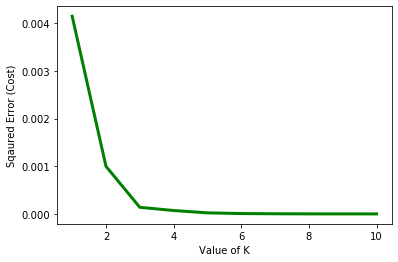

In [218]:
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [219]:
kclusters = 3     # No.of Clusters
ny_grouped_clustering = grouped_indian.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 2, 0, 0, 0, 2])

In [220]:
grouped = grouped_indian.copy(deep=True)
grouped['Cluster Labels'] = kmeans.labels_    # Adding the labels to the data
grouped['Cluster Labels'] = grouped['Cluster Labels'].astype(int)  # Float is sometimes returned
print(grouped.shape)
grouped.head(10)

(70, 3)


Neighborhood  Indian Restaurant  Cluster Labels
0          Bath Beach           0.000000               0
1           Bay Ridge           0.012500               2
2  Bedford Stuyvesant           0.000000               0
3         Bensonhurst           0.000000               0
4        Bergen Beach           0.000000               0
5         Boerum Hill           0.011494               2
6        Borough Park           0.000000               0
7      Brighton Beach           0.000000               0
8   Broadway Junction           0.000000               0
9    Brooklyn Heights           0.020000               2

In [221]:
to_merged = grouped.join(brook_venues.set_index("Neighborhood"), on="Neighborhood") # Merge with the original data
print(to_merged.shape)
to_merged.head()

(2719, 9)


Neighborhood  Indian Restaurant  Cluster Labels  Neighborhood Latitude  \
0   Bath Beach                0.0               0              40.599527   
0   Bath Beach                0.0               0              40.599527   
0   Bath Beach                0.0               0              40.599527   
0   Bath Beach                0.0               0              40.599527   
0   Bath Beach                0.0               0              40.599527   

   Neighborhood Longitude                    Venue  Venue Latitude  \
0              -73.998754  Bay Parkway Water Front       40.595941   
0              -73.998754         Bensonhurst Park       40.597065   
0              -73.998754                Five Guys       40.595236   
0              -73.998754                   Carvel       40.598733   
0              -73.998754        Pino's Ristorante       40.600955   

   Venue Longitude      Venue Category  
0       -74.000917           Surf Spot  
0       -73.998340                Park  
0       -74.000225        Burger Joint  
0       -73.997670      Ice Cream Shop  
0       -74.000806  Italian Restaurant

### Visualizaing the Clusters

In [222]:
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [224]:
to_merged[to_merged['Cluster Labels']==0]  # Cluster 0

Neighborhood  Indian Restaurant  Cluster Labels  \
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
0            Bath Beach                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0               0   
2    Bedford Stuyvesant                0.0 

In [225]:
to_merged[to_merged['Cluster Labels']==1]  # Cluster 1

Neighborhood  Indian Restaurant  Cluster Labels  \
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15               Clinton Hill           0.031915               1   
15   

In [226]:
to_merged[to_merged['Cluster Labels']==2]  # Cluster 2

Neighborhood  Indian Restaurant  Cluster Labels  \
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2   
1          Bay Ridge           0.012500               2

In [231]:
t = to_merged[to_merged['Cluster Labels']==0]
print('Number of Indian Restaurants in Cluster 0: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==1]
print('Number of Indian Restaurants in Cluster 1: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==2]
print('Number of Indian Restaurants in Cluster 2: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))

Number of Indian Restaurants in Cluster 0: 0
Number of Indian Restaurants in Cluster 1: 5
Number of Indian Restaurants in Cluster 2: 9


### New Analysis :

<ul>
<b> <li> <p> Cluster 2 has the most number of Indian Restaurants and is therefore not considered.</p> <br> </li>
    <li> <p> Cluster 1 is has medium number of Restaurants. </p> <br> </li>
    <li> <p> <u> Cluster 0 </u> is ideal as no restaurants are present. Therefore we can look into the places in this Cluster.</p> <br> </li> </b> 
</ul>

### Analyzing Cluster 0

<b> Most common Type of Restaurant(s) in each Neighborhood. </b>

In [284]:
temp = to_merged[to_merged['Cluster Labels']==0]
x = temp[temp['Venue Category'].str.contains('Restaurant')].groupby(['Neighborhood','Venue Category']).count()
y = x.reset_index().rename(columns={'Venue':'Count'})[['Neighborhood','Venue Category','Count']].sort_values(by='Count',ascending=False).reset_index(drop=True).head(6)
y

Neighborhood        Venue Category  Count
0   Carroll Gardens    Italian Restaurant     11
1        South Side   American Restaurant      6
2  Prospect Heights    Mexican Restaurant      5
3          Red Hook    Seafood Restaurant      4
4           Erasmus  Caribbean Restaurant      4
5       Bensonhurst    Chinese Restaurant      4

<b> Most common Places in the Cluster. </b>

In [285]:
temp.groupby('Venue Category').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Venue Category','Count']].sort_values('Count',ascending=False).reset_index(drop=True).head(10)

Venue Category  Count
0         Pizza Place     96
1         Coffee Shop     73
2                 Bar     52
3       Deli / Bodega     50
4              Bakery     48
5       Grocery Store     41
6  Chinese Restaurant     39
7  Italian Restaurant     38
8                Bank     36
9          Donut Shop     36

<p style="font-size:18px" "font-family:helvetica"> From the table above we can see that the most common places in this Cluster are Pizza Places, Coffee Shops etc and are mainly fast food places. The 2 most common type of restaurants are <u> Italian </u> and <u> Chinese </u>.</p>

<b> Most Common Neighborhoods in the Cluster </b>

In [283]:
clus_0  = to_merged[to_merged['Cluster Labels']==0].groupby('Neighborhood').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Neighborhood','Count']].sort_values('Count',ascending=False).reset_index(drop=True)
print('Number of Neighborhoods: {}'.format(len(clus_0)))
clus_0.head()

Number of Neighborhoods: 60


Neighborhood  Count
0  Carroll Gardens    100
1       South Side    100
2       North Side    100
3         Downtown     98
4      Cobble Hill     94

### Final Analysis : 

<p style="font-size:18px" "font-family:helvetica"> Looking at nearby venues, it seems Cluster 0 might be a good location as there are not a lot of Indian restaurants in these areas. There are 60 odd neighborhoods present in the Cluster and the most common ones being <b> Carroll Gardens, South Side, North Side, Downtown and Cobble Hill </b> in <b> Brooklyn. </b></p>

<p style="font-size:18px" "font-family:helvetica"> Therefore our Indian Restaurant can be opened in any of these neighborhoods  with little to no competition. <br> 
Nonetheless, if the food is affordable, authentic and has good taste, I am confident that it will have great following everywhere. </p>

## Case 2 : Staten Island

<p style="font-size:18px" "font-family:helvetica"> Staten Island <u> (24,359)</u> has only slightly fewer Indian Americans compared to Brooklyn <u> (25,270) </u> so it might be worth looking into. </p>

### Filtering Indian Restaurants

In [291]:
si_indian = si_venues[si_venues['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
si_indian.rename(columns={'Venue Latitude':'Latitude','Venue Longitude':'Longitude'},inplace=True)
si_indian.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Castleton Corners              40.613344              -74.119182   
1           New Dorp              40.572581              -74.116481   

               Venue   Latitude  Longitude     Venue Category  
0         Spice Rack  40.613330 -74.123173  Indian Restaurant  
1  Taste Of India II  40.572127 -74.112674  Indian Restaurant

### Plotting the Venues

In [300]:
loc = location('Staten Island, NY')

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


In [303]:
plot_map(si_indian,loc,zoom=13)

### Final Anaylsis :

<ul>
<li><p style="font-size:18px""font-family:helvetica"> Since there are only 2 restaurants, competition is very low.</p><br></li>
<li><p style="font-size:18px""font-family:helvetica"> Staten Island also has a high density of Indian Americans per sq mile so foot traffic should not be a problem. </p><br></li>
<li><p style="font-size:18px""font-family:helvetica"> But the lack of Indian Restaurnats can also hint at various other problems like a Licensing, stringent community norms etc, something which should be looked into before making a decision. </p><br></li>
<li><p style="font-size:18px""font-family:helvetica"> Any neighborhood may be considered based on preference, convenience etc. </p><br></li>
</ul>